In [1]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

!pip install kmc2

!ls -lha kaggle.json
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

# 캐글연동을 위한 토큰 입력
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# 버전이 1.5.6 이 아니면, 진행할 수 없다
! kaggle -v

     |████████████████████████████████| 25.0MB 49.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 1.4MB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30
     |████████████████████████████████| 102kB 6.1MB/s 
     |████████████████████████████████| 163kB 33.8MB/s 
  Created wheel for kmc2: filename=kmc2-0.1-cp36-cp36m-linux_x86_64.whl size=252224 sha256=ed2144f9314f77057f433b5a5999c60969503cd6e21885889ae7b42ed939d8ec
  Stored in directory: /root/.cache/pip/wheels/5c/ba/f0/4c8b421be72d4f2d1a93233c2f6f591e7d8b0bda05a1f4616f
Successfully built kmc2
-rw-r--r-- 1 root root 62 Dec 14 09:36 kaggle.js

In [2]:
! kaggle competitions download -c 2019-ml-finalproject
! unzip 2019-ml-finalproject.zip

100% 65.0M/65.0M [00:01<00:00, 17.4MB/s]
100% 65.0M/65.0M [00:01<00:00, 51.1MB/s]
Archive:  2019-ml-finalproject.zip
  inflating: Label2Names.csv         
  inflating: sample_submission.csv   
  inflating: testAll_v2/image_0001.jpg  
  inflating: testAll_v2/image_0002.jpg  
  inflating: testAll_v2/image_0003.jpg  
  inflating: testAll_v2/image_0004.jpg  
  inflating: testAll_v2/image_0005.jpg  
  inflating: testAll_v2/image_0006.jpg  
  inflating: testAll_v2/image_0007.jpg  
  inflating: testAll_v2/image_0008.jpg  
  inflating: testAll_v2/image_0009.jpg  
  inflating: testAll_v2/image_0010.jpg  
  inflating: testAll_v2/image_0011.jpg  
  inflating: testAll_v2/image_0012.jpg  
  inflating: testAll_v2/image_0013.jpg  
  inflating: testAll_v2/image_0014.jpg  
  inflating: testAll_v2/image_0015.jpg  
  inflating: testAll_v2/image_0016.jpg  
  inflating: testAll_v2/image_0017.jpg  
  inflating: testAll_v2/image_0018.jpg  
  inflating: testAll_v2/image_0019.jpg  
  inflating: testAll_v2/imag

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from scipy.cluster.vq import vq
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import cv2 
import os
import pickle

import kmc2
import cupy as xp
from svm import SVM
from tqdm import tqdm

from PIL import Image

import matplotlib.pyplot as plt
#from sklearn.svm import SVC

In [0]:
# 이미지 리사이즈
def resize(dir,step):
  img= cv2.imread(dir)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_gray=cv2.resize(img_gray, (step,step))
  return img_gray 

def load_train_data(img_size,step_size):
  train_root_path="./train"
  len(os.listdir(train_root_path))
  train_data=[]
  label=[]
  train_des=[]
  cn=1
  for lis in tqdm(class_name):
  #for lis in tqdm(class_name[:25]):
    img_list=os.listdir(train_root_path+'/'+lis)
    for i in img_list:
      gray=resize(train_root_path+'/'+lis+'/'+i,img_size)
      train_des.append(dense_sift(gray,step_size))
      #train_data.append(gray)
      label.append(cn)
    cn+=1
  train_des=np.array(train_des)
  return train_des,label

def load_test_data(img_size,step_size):
  test_root_path="./testAll_v2"
  len(os.listdir(test_root_path))
  test_data=[]
  test_des=[]
  test_name=[]
  lis=os.listdir(test_root_path)
  lis.sort()
  for lis in tqdm(lis):
      gray=resize(test_root_path+'/'+lis,img_size)
      #test_data.append(gray)
      test_des.append(dense_sift(gray,step_size))
      test_name.append(lis)

  test_des=np.array(test_des)
  return test_des,test_name
    
# SIFT weak feature extraction
def weak_sift(gray):
  sift=cv2.xfeatures2d_SIFT.create()
  kp,des=sift.detectAndCompute(gray,None)

  return des

#SIFT dense feature extraction
def dense_sift(gray,step):
  sift=cv2.xfeatures2d_SIFT.create()
  keypoints=[]
  w,h=gray.shape
  keypoints=[cv2.KeyPoint(i,j,step) for i in range(0,h,step) for j in range(0,w,step)]
  kp,des=sift.compute(gray,keypoints)
  
  return des 

# make code word and histogram
def histogram(data_set,size):
  train_his=[]
  for i in data_set:
    den=dense_sift(i,8)
    predict=Kmeans.predict(den)
    count=np.bincount(predict,minlength=size)
    train_his.append(count)
  return train_his

def histogram_vq(data_des):
  his=[]
  for i in tqdm(data_des):
    code_word=vq(i,codebook)[0]
    count=np.bincount(code_word,minlength=400)
    his.append(count)
  return his  

def SVM_GPU(X_train,X_val,y_train,C):
  X_train = xp.asarray(X_train)
  X_val = xp.asarray(X_val)
  y_train = xp.asarray(y_train)

  #svm = SVM(kernel='linear', kernel_params={'sigma': 15}, classification_strategy='ovr', x=X_train, y=y_train)
  svm = SVM(kernel='rbf',class_weight='balanced', kernel_params={'C':1},x=X_train, y=y_train)

  svm.fit(X_train, y_train)

  X_val = xp.asarray(X_val)
  val_fit=svm.predict(X_val)

  test_h = xp.asarray(test_h)
  result=svm.prdict(test_h)
  result=xp.asnumpy(result)

  return result,val_fit

def SVM_Grid(X_train,X_val,y_train,test_h,c,g):

  svm = SVC(kernel='rbf',class_weight='balanced')
  param_grid = {'C':c,'gamma':g}
  grid = GridSearchCV(svm, param_grid, cv=5)

  grid.fit(X_train,y_train)
  print(grid.best_params_)
  val_fit=grid.predict(X_val)
  result=grid.predict(test_h)
  return result,val_fit

def SVM_(X_train,y_train,X_test,c,g):
  svm = SVC(kernel='rbf',C=c,gamma=g)
  svm.fit(X_train,y_train)
  result=svm.predict(X_test)
  return result


def make_result_csv(result,test_name):
  result_=np.append(['Category'],result)
  result_id=np.append(['Id'],test_name)
  df = pd.DataFrame(result_,result_id,columns=[' '])
  df.to_csv('results_.csv',index=True, header=False)
  print(df)

def save_array(file_name,arr):
  with open(file_name,'wb') as f:
    pickle.dump(arr,f)
def load_array(file_name):
  with open(file_name,'rb') as f:
    arr=pickle.load(f)
  return arr

In [5]:
df_data=pd.read_csv('/content/Label2Names.csv',header=None)
class_name=df_data[1].tolist()
class_name.append('BACKGROUND_Google')
df_data

,0,1
0,1,Faces
1,2,Faces_easy
2,3,Leopards
3,4,Motorbikes
4,5,accordion
...,...,...
96,97,wheelchair
97,98,wild_cat
98,99,windsor_chair
99,100,wrench


In [8]:
train_des,label=load_train_data(256,8)
test_des,test_name=load_test_data(256,8)

100%|██████████| 102/102 [04:34<00:00,  2.72s/it]


In [9]:
train_des.shape

(3060, 1024, 128)

In [10]:
test_des.shape

(1692, 1024, 128)

In [0]:
train_des=np.array(train_des).reshape(-1,128)
test_des=(np.array(test_des)).reshape(-1,128)

In [12]:
train_des.shape

(3133440, 128)

In [13]:
'''
label_lda=[]
for i in range(1,103):
  tmp=[i]*30*1024
  label_lda.append(tmp)
label_lda=np.array(label_lda).reshape(-1)
label_lda.shape
lda=LinearDiscriminantAnalysis()
train_des=lda.fit_transform(train_des,label_lda)
test_des=lda.transform(test_des)
'''

'\nlabel_lda=[]\nfor i in range(1,103):\n  tmp=[i]*30*1024\n  label_lda.append(tmp)\nlabel_lda=np.array(label_lda).reshape(-1)\nlabel_lda.shape\nlda=LinearDiscriminantAnalysis()\ntrain_des=lda.fit_transform(train_des,label_lda)\ntest_des=lda.transform(test_des)\n'

In [0]:
pca=PCA(64)
train_des=pca.fit_transform(train_des)
test_des=pca.transform(test_des)

In [20]:
pca.n_components_

64

In [0]:
des_vec=train_des

In [0]:
train_des=train_des.reshape(3060,1024,-1)
test_des=test_des.reshape(1692,1024,-1)

In [23]:
des_vec.shape

(3133440, 64)

In [24]:
codebooksize=400
seeding = kmc2.kmc2(des_vec, codebooksize) 
Kmeans = MiniBatchKMeans(codebooksize, init=seeding,init_size=400).fit(des_vec)
codebook = Kmeans.cluster_centers_
codebook.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Explicit initial center position passed: performing only one init in MiniBatchKMeans instead of n_init=3
  This is separate from the ipykernel package so we can avoid doing imports until


(400, 64)

In [25]:
h_list=histogram_vq(train_des)
h_list=np.array(h_list)
print(h_list.shape)

100%|██████████| 3060/3060 [00:09<00:00, 338.18it/s]


(3060, 400)


<BarContainer object of 400 artists>

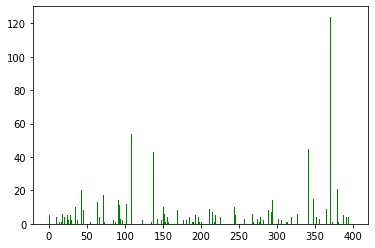

In [26]:
plt.bar(range(400),h_list[0,:] , color='g')

In [27]:
test_h=histogram_vq(test_des)
test_h=np.array(test_h)

100%|██████████| 1692/1692 [00:04<00:00, 339.90it/s]


In [0]:
scaler=StandardScaler()
h_list_=scaler.fit_transform(np.array(h_list,int))
test_h_=scaler.transform(np.array(test_h,int))

In [0]:
result=SVM_Grid(h_list_,label,test_h_,[4,10],[0.001,0.0001])
#result=SVM_(h_list_,label,test_h_,4,0.001)
#result=SVM_GPU(h_list_,label,test_h_,[4,10],[0.001,0.0001])

In [44]:
make_result_csv(result,test_name)

                        
Id              Category
image_0001.jpg        38
image_0002.jpg        89
image_0003.jpg        92
image_0004.jpg        51
...                  ...
image_1688.jpg        11
image_1689.jpg        61
image_1690.jpg        48
image_1691.jpg        38
image_1692.jpg        82

[1693 rows x 1 columns]


In [45]:
! kaggle competitions submit -c 2019-ml-finalproject -f results_.csv -m "sanhee-1214_pca_scal"

100% 29.6k/29.6k [00:03<00:00, 9.20kB/s]
Successfully submitted to 2019.Fall.PatternRecognition 